# Load Place Plus 2.0 for Tensorflow
* First make sure to download all the folders using PyTorch (https://github.com/aleksandrskoselevs/place-pulse-dataset/blob/main/training_example.ipynb)
* Read both image and the associated qscore for tensorflow
* **Place Pulse 2.0** is a crowdsourced dataset and platform developed by MIT Media Lab that measures human perceptions of urban environments. It builds upon the original Place Pulse project by expanding its scope to include 56 cities and collecting data on six perceptual indicators: beautiful, boring, depressing, lively, safe, and wealthy.

## 1. Extract study_id for defined study_type

In [298]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import load_img, img_to_array
from transformers.image_transforms import to_pil_image
import transformers
from transformers.models.auto.image_processing_auto import image_processors

In [310]:
keras.mixed_precision.set_global_policy('mixed_float16') # Enable mixed precision

In [49]:
def crop_google_logo(img):
    return tf.image.crop_to_bounding_box(img, 0, 0, img.size[1]- 25, img.size[0])

In [3]:
os.chdir('/home/eiji/place-pulse-dataset')
cdir = os.getcwd()

In [4]:
# Read csv file
study_types = {         # Adapted from `studies.tsv`
            'safe': '50a68a51fdc9f05596000002',
            'lively': '50f62c41a84ea7c5fdd2e454',
            'clean': '50f62c68a84ea7c5fdd2e456',
            'wealthy': '50f62cb7a84ea7c5fdd2e458',
            'depressing': '50f62ccfa84ea7c5fdd2e459',
            'beautiful': '5217c351ad93a7d3e7b07a64'
        }

table = pd.read_csv(os.path.join(cdir, 'data', 'qscores.tsv'), sep='\t')

In [282]:
# Identify indices of 'study_id' corresponding to the selected study_type
study_type = study_types['beautiful']
idx0 = table.index[table['study_id'] == study_type]

# randomly choose 10
num_train_samples = 200
idx = np.random.choice(idx0, num_train_samples)
idx_test = np.random.choice(idx0, num_train_samples // 2)

# Extract IDs and corresponding qscores
ids = table.loc[idx, 'location_id'].values
qscore = table.loc[idx, 'trueskill.score'].values

# Compile in dictionary
img_score_dict = {}
for i, id in enumerate(ids):
    img_score_dict[id] = float(qscore[i])

print(img_score_dict)

{'5140cc43fdc9f04926002d61': 21.3489099683, '513d6896fdc9f03587004411': 23.057919633, '5185d3f2fdc9f03fd5001352': 30.9491612609, '513e20d9fdc9f0358700a2f4': 28.1730757115, '5140cb58fdc9f04926002b1d': 20.8343098766, '50f60b91beb2fed910000090': 25.8436449623, '5185cff0fdc9f03fd5000fa6': 30.5883503864, '50f448b5fdc9f065f000423a': 27.2105765302, '51413327fdc9f049260041e4': 15.4522754036, '51413993fdc9f049260054d3': 24.2621708769, '513d9a75fdc9f035870076d4': 30.4155370815, '50f5ebcefdc9f065f0008592': 11.6130828295, '513d78d9fdc9f035870062e1': 21.2901312089, '513d7b7efdc9f03587006bae': 26.6680879191, '51414868fdc9f04926006caf': 30.9277873173, '513d303ffdc9f035870026fb': 25.0, '513e65a3fdc9f0358700b9c4': 34.8913612843, '513d7b08fdc9f03587006a1b': 38.2716912883, '513d30b7fdc9f0358700275a': 28.1730757115, '513e1ffbfdc9f0358700a0a6': 22.1195088028, '51414fc0fdc9f04926007b8a': 22.4794654891, '514094f0fdc9f04926000914': 15.025017161, '50f5ecf3fdc9f065f0008b84': 27.4868686647, '513f2d79fdc9f0358700

In [283]:
# Extract images corresponding to the extracted ids
img_dir = os.path.join(cdir, 'data', 'images')
images = ids + '.jpg'
input_img_paths = [os.path.join(img_dir, image) for image in images]
img_size = (224, 224)
num_imgs = len(input_img_paths)

In [284]:
def path_to_input_image(path):
    img = load_img(img_path, target_size=(256, 256))
    img = crop_google_logo(img)
    resized_img = tf.image.resize(img, (224, 224), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    img_arr = tf.image.convert_image_dtype(resized_img, tf.float32)
    return img_arr

In [285]:
input_imgs = np.zeros((num_imgs, ) + img_size + (3, ), dtype="float32")
targets = np.zeros((num_imgs, ), dtype="float32")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = img_score_dict[os.path.splitext(os.path.basename(input_img_paths[i]))[0]]

## Prepare data

In [286]:
num_val_samples = num_train_samples // 2
train_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [305]:
# Use VGG16
conv_base = keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_base.trainable = False
conv_base.summary()

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="perception_score_CNN_sample.keras", save_best_only=True, monitor='val_loss'),
    keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10),
]


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [316]:
# When conv.summary() is run, codes below give errors...
## Remember that outputs do not need to have the same shape, as our outputs are not image segmentation
## Do not use SeparableConv2D (this assumes independent among channels, but we have RGB, which are very correlated with each other)
inputs = keras.Input(shape=img_size + (3, ))
# already scaled to [0, 1]
x = data_augmentation(inputs)
# x = keras.applications.vgg16.preprocess_input(x) # adding this seems to confuse the model. WHY?
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
# x = layers.Conv2D(64, 3, strides=2, padding='same')(inputs)
# x = layers.Conv2DTranspose(64, 3, strides=2, padding='same')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [317]:
# Train the model
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              loss='mse',
              metrics=['mae'])
history = model.fit(train_imgs, train_targets, epochs=100, batch_size=64, validation_data=(val_imgs, val_targets))

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 595ms/step - loss: 627.8823 - mae: 24.3395 - val_loss: 638.9846 - val_mae: 24.6087
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 364ms/step - loss: 635.1607 - mae: 24.4438 - val_loss: 638.9846 - val_mae: 24.6087
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 362ms/step - loss: 624.9736 - mae: 24.3337 - val_loss: 638.9846 - val_mae: 24.6087
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 361ms/step - loss: 609.7530 - mae: 23.9151 - val_loss: 478.2888 - val_mae: 21.0968
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 364ms/step - loss: 435.6275 - mae: 19.9383 - val_loss: 391.3597 - val_mae: 18.9278
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 369ms/step - loss: 327.9410 - mae: 17.1587 - val_loss: 326.7050 - val_mae: 17.1369
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 374ms/step - loss: 276.9736 - mae: 15.5656 - val_loss: 278.8997 - val_mae: 15.6776
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 358ms/step - loss: 238.5419 - mae: 14.1717 - val_loss: 239.0229 - val_mae: 14.3480
Epoch 9/100
2/2 

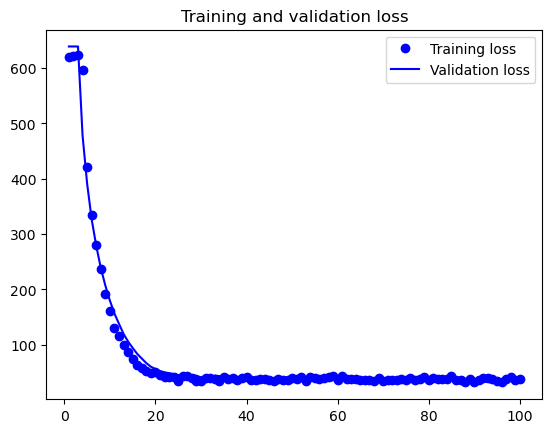

In [318]:
# Visualize
epochs = range(1, len(history.history['loss']) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model and predict
